<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gathering visualizations ideas

# Setup env


In [0]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# test, peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# test, modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27 12:01 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27 12:01 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27 12:01 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27 12:01 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27 12:01 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27 12:01 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27 12:01 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27 12:01 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27 12:01 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27 12:01 9_soul-groove9_105_beat_4-4.mid
total 20
-rw------- 1 root root 15739 May 23 00:39 data_prep.py
drwx------ 2 root root  4096 May 10 13:31 __pycache__


## Auto reload module

I'm now using a module edited and saved to google drive which is automatically pushed to the cloud and made available to the colab env. Changes need time to propagate, and imports don't 'reimport' to load changes, so trying the following...

Note the code below is not very reliable, it seems to work occasionally, after some time, but haven't been able to work out the pattern to it. 

If in a hurry, brute force loading of changes by restarting the runtime.

In [0]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [5]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 1.9MB/s 


In [6]:
# imports
import pandas as pd
import math

# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep

import matplotlib.pyplot as plt


LOADING - data_prep.py module name is: data_prep


In [7]:
# testing auto reload of modules 
data_prep.test_function_call('bling')

test function called worked! :)  bling


## Pandas display options

In [0]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 200
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


## Test creating object from custom module

In [0]:
gmt = data_prep.GrooveMidiTools

In [10]:
file_name = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'
midi_file = data_prep.MIDI_File_Wrapper(file_name, gmt.mappings)

FILE: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
    tracks: [<midi track 'Base Midi' 1037 messages>]
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    last note_on: 30634
    good instruments: 4, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 42.0: 'Closed Hi Hat (42)', 51.0: 'Ride Cymbal 1 (51)'}


... the above verifies I'm able to create custom objects from custom code, great!


# Visualization code: broken_barh

### Setup file to chart

In [11]:
file_name = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'
midi_file = data_prep.MIDI_File_Wrapper(file_name, gmt.mappings)
f = midi_file


FILE: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
    tracks: [<midi track 'Base Midi' 1037 messages>]
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    last note_on: 30634
    good instruments: 4, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 42.0: 'Closed Hi Hat (42)', 51.0: 'Ride Cymbal 1 (51)'}


### Setup timing info

In [0]:
# capture timing data in df

mtt = data_prep.MidiTimingTools(file_name, f.ticks(), f.tempo_us(), f.ts_num(), f.ts_denom(), f.last_hit())
# print(mtt)

f_df = f.df_midi_data
f_df = f_df[f_df['msg_type'] == 'note_on'].copy() # we only care about 'note_on' events
beats_col, offsets_col = mtt.get_offsets(f_df[f.cum_ticks_col])
f_df['offset'] = offsets_col
f_df['beat'] = beats_col

### Specify start bar and number of bars to chart
The next cell is all you need, put in what bar to start at and how many bars to print and hit the go button and it should do the rest ...

In [0]:
# specify what bar to start chart
bar_to_start=1

# specify how many bars to include
bars_to_render=2

# instrument filter
# leave empty to chart all in file, otherwise instruments filtered
# to this list, and will be ordered from bottom to top y-axis.
#instruments_to_render=[]  # good empty list
instruments_to_render=[36, 38, 51]  # good empty list
# instruments_to_render=[38, 36, 42]  # good list
# instruments_to_render=[33, 32, 49, 999]  # broken list



### Chart calculations

In [14]:
# time filtering the df here...

ts_num = f.ts_num()
ts_den = f.ts_denom()
ticks_per_bar=mtt.ticks_per_bar()

# workout ticks
start_tick, end_tick = mtt.get_tick_range(bar_to_start, bars_to_render)
print('start tick: {}, end tick: {}'.format(start_tick, end_tick))
print('total to print, ticks: {}, bars: {}'.format(end_tick - start_tick, (end_tick - start_tick) /ticks_per_bar))

# filter our events to render
time_filtered_df = f_df[f_df.total_ticks >= start_tick]  # chop off early ones
time_filtered_df = time_filtered_df[time_filtered_df.total_ticks < end_tick] # chop off later ones

start tick: -60.0, end tick: 3780.0
total to print, ticks: 3840.0, bars: 2.0


In [15]:
instr_in_file = time_filtered_df.note.unique()
print('instruments in file: {}, names: {}'.format(instr_in_file, data_prep.MidiTools.getInstruments(instr_in_file)))

instr_time_filtered_df = None 

# instrument filtering the df here ...
if len(instruments_to_render) == 0:
  instr_time_filtered_df = time_filtered_df[time_filtered_df['note'] != None]
  instruments_to_render = instr_time_filtered_df.note.unique().sort()
else:
  instr_time_filtered_df = time_filtered_df[time_filtered_df['note'].isin(instruments_to_render)]

num_instruments = len(instruments_to_render)

names = data_prep.MidiTools.getInstruments(instruments_to_render)
print('final instruments: {}, names: {}'.format(instruments_to_render, names ))


instruments in file: [42. 36. 51. 38.], names: ['Closed Hi Hat (42)', 'Bass Drum 1 (36)', 'Ride Cymbal 1 (51)', 'Acoustic Snare (38)']
final instruments: [36, 38, 51], names: ['Bass Drum 1 (36)', 'Acoustic Snare (38)', 'Ride Cymbal 1 (51)']


### Build data structure required by broken_barh

In [16]:
bag_of_instruments = {}
for i in instruments_to_render:
  instrument_hits = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'total_ticks']
  instrument_hit_duples = []
  for i_time in instrument_hits:
    instrument_hit_duples.append((i_time, 10))

  bag_of_instruments[i] = instrument_hit_duples


print('bag_of_instruments: {}'.format(bag_of_instruments))

bag_of_instruments: {36: [(9, 10), (226, 10), (344, 10), (1195, 10), (1314, 10), (1938, 10), (2156, 10), (3111, 10), (3254, 10)], 38: [(513, 10), (863, 10), (1116, 10), (1468, 10), (1808, 10), (2051, 10), (2417, 10), (2768, 10), (3024, 10), (3381, 10), (3711, 10)], 51: [(15, 10), (258, 10), (495, 10), (746, 10), (996, 10), (1236, 10), (1465, 10), (1702, 10), (1935, 10), (2159, 10), (2407, 10), (2661, 10), (2902, 10), (3148, 10), (3377, 10), (3617, 10)]}


In [0]:
from itertools import cycle
cycol = cycle('bgrcmykw')  # use this for colours


In [0]:
bin_size = mtt.bin_size();
my_xticks = list(range(int(start_tick) + int(bin_size/2), int(end_tick), bin_size))

### Plot the broken_barh chart





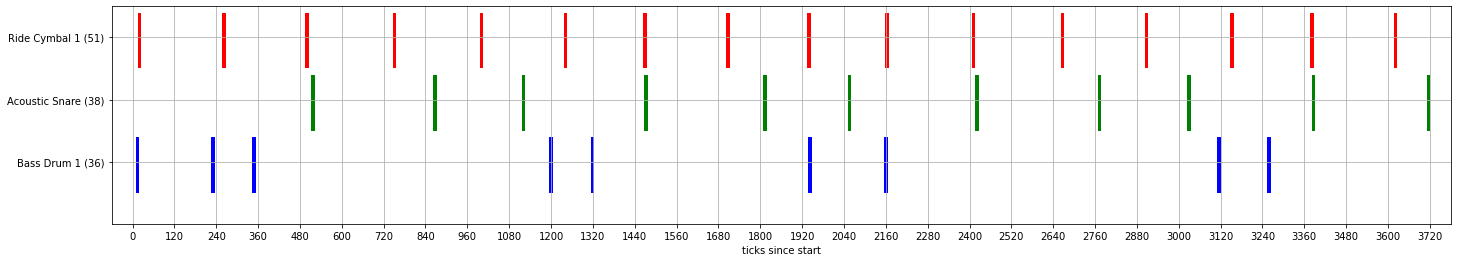

In [19]:

#############################################
## Show plot
#############################################
 
fig, ax = plt.subplots()
fig.set_size_inches(12*bars_to_render, 1+num_instruments, forward=True)
 
# loop for each instrument
y_axis = 0
for i in instruments_to_render:
  y_axis += 10
  ax.broken_barh(bag_of_instruments[int(i)], (y_axis, 9), facecolors=next(cycol));


ax.set_ylim(5, (num_instruments*10)+10);
ax.set_xlim(start_tick, end_tick);
ax.set_xlabel('ticks since start');
ax.set_yticks(list(range(15, ((num_instruments+1)*10)+5, 10)));
ax.set_yticklabels(names);

ax.set_xticks(my_xticks);
ax.grid(True);
 
plt.show();


# Visualization: offset chart  (TODO)




In [20]:
bag_of_instrument_hits = {}
for i in instruments_to_render:
  instrument_hits = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'total_ticks']
  instrument_hit_array = []
  for i_time in instrument_hits:
    instrument_hit_array.append(i_time)

  bag_of_instrument_hits[i] = instrument_hit_array


print('bag_of_instrument_hits: {}'.format(bag_of_instrument_hits))

bag_of_instrument_offsets = {}
for i in instruments_to_render:
  instrument_offsets = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'offset']
  instrument_offset_array = []
  for i_time in instrument_offsets:
    instrument_offset_array.append(i_time)

  bag_of_instrument_offsets[i] = instrument_offset_array


print('bag_of_instrument_offsets: {}'.format(bag_of_instrument_offsets))

bag_of_instrument_hits: {36: [9, 226, 344, 1195, 1314, 1938, 2156, 3111, 3254], 38: [513, 863, 1116, 1468, 1808, 2051, 2417, 2768, 3024, 3381, 3711], 51: [15, 258, 495, 746, 996, 1236, 1465, 1702, 1935, 2159, 2407, 2661, 2902, 3148, 3377, 3617]}
bag_of_instrument_offsets: {36: [9, -14, -16, -5, -6, 18, -4, -9, 14], 38: [33, 23, 36, 28, 8, 11, 17, 8, 24, 21, -9], 51: [15, 18, 15, 26, 36, 36, 25, 22, 15, -1, 7, 21, 22, 28, 17, 17]}


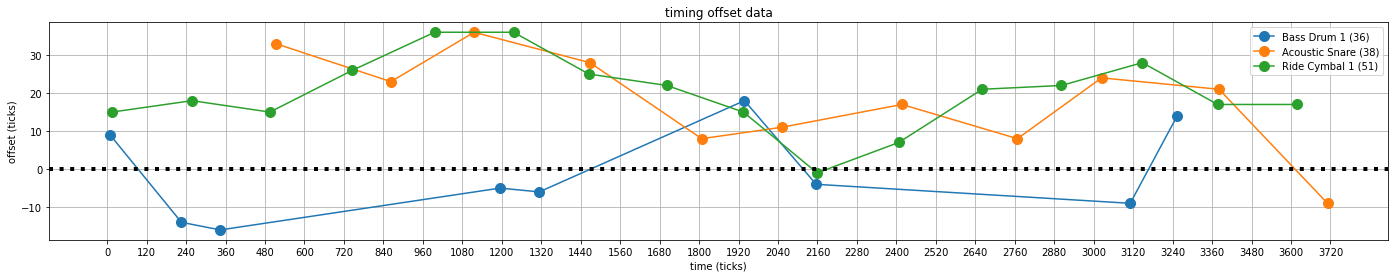

In [21]:

fig, ax = plt.subplots();
fig.set_size_inches(12*bars_to_render, 1+num_instruments, forward=True);
 

# loop for each instrument
for i in instruments_to_render:
  ax.plot(bag_of_instrument_hits[i], bag_of_instrument_offsets[i], '-o', ms= 10, label=data_prep.MidiTools.mapInstrument(i));

ax.set(xlabel='time (ticks)', ylabel='offset (ticks)', title='timing offset data');

#Add horizontal and vertical lines
plt.axhline(0, color='black', linestyle='dotted', linewidth=4);  #horizontal line

ax.set_xticks(my_xticks);

#ax.grid(axis='y')
ax.grid();
ax.legend();

#fig.savefig("test.png")
plt.show();